In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import pandas as pd
import sys 
sys.path.append("../")
from src.misc_utils import *
from src.model_utils import *
from src.sequence_utils import *
from src.portfolio import *
from src.data import update,prepare_data
from yahooquery import Ticker
import os
from datetime import datetime,timedelta
import sqlite3

In [3]:
DATA_DIR="/home/notebooks/"
MODELS_DIR="/home/notebooks/"
DB_PATH="/home/stock_db"
HORIZON=7
PRICE_COLUMN="Close"
LOOKBACK=180 
HISTORY=14
FORECAST_STEPS=1
FUTURE=0
TARGET=f"log_return_{HORIZON}"

In [4]:
last_date=datetime.today()

In [5]:
data=prepare_data(last_date=last_date,
                  db_path=DB_PATH,
                  price_column=PRICE_COLUMN,
                  lookback=LOOKBACK,
                  horizon=HORIZON,
                  forecast_steps=FORECAST_STEPS,
                  update_data=True,
                  test_ratio=.1,
                  val_ratio=0)

In [7]:
model_path=get_latest_model_path(models_dir=MODELS_DIR,prefix="model-")         
norm=Normaliser()
norm.load(f"{model_path}/normaliser")
data=norm.normalise(data)
num_features=["Close_scaled",
              "log_return_1_shift_-1",
              "log_return_2_shift_-2",
              "log_return_3_shift_-3",
              "log_return_4_shift_-4",
              "log_return_5_shift_-5",
              "log_return_6_shift_-6",
              "log_return_7_shift_-7",
]
initial_available_date=data[~data[TARGET].isnull()].date.min()

enc=Encoder()
enc.load(f"{model_path}/encoder")
features=enc.get_encoded_features()
features=features+num_features
data=enc.apply(data)
inference_date=data[(data.weekend==0)&(data.holiday=="no_holiday")&(data.date>data[~data[TARGET].isnull()][f"lag_date_Close_{HORIZON}"].max())].date.min()
sequencer=TimeseriesSquencer(
    features=features,
    target=TARGET,
    history=HISTORY,
    future=FUTURE,
    steps=FORECAST_STEPS,
    id_column="ticker",
    time_column="date",
    data_end_date=inference_date.strftime("%Y-%m-%d"),
    include_target_feature=False,
    extra_id_columns=[])
train_dict=sequencer.sequence_timeseries(data[data.train==1].dropna())
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                            patience=10,
                                              restore_best_weights=True,
                                            mode='min') 
def same_sign(y_true,y_pred):
    return tf.reduce_sum(tf.abs(tf.cast(tf.sign(y_true),dtype=tf.float64)+tf.cast(tf.sign(y_pred),dtype=tf.float64))/2)/tf.reduce_sum(tf.abs(tf.cast(tf.sign(y_true),dtype=tf.float64)))    


   
model = tf.keras.models.load_model(model_path, custom_objects={'same_sign':same_sign})

In [8]:
model_path

'/home/notebooks//model-2023-06-15'

In [9]:
tmp=data[(data.working_day==1)].copy()

data_dict=sequencer.sequence_timeseries(tmp)

result=get_predictions(model,tmp,data_dict,steps=[0])

539/539 [==============================] - 12s 20ms/step


In [10]:
rmse = lambda x,y:np.sqrt(np.mean((x-y)**2))

<AxesSubplot: xlabel='date'>

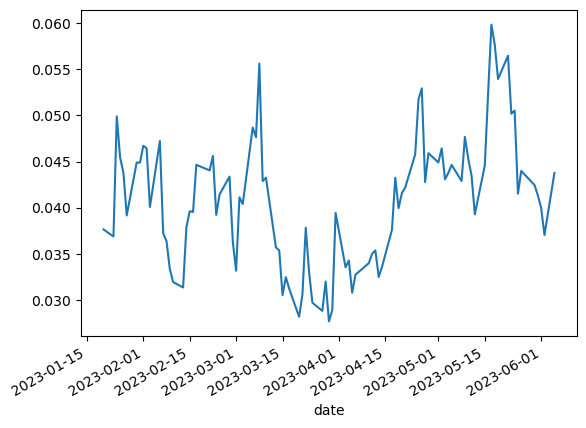

In [11]:
result.groupby("date").apply(lambda x: rmse(x[TARGET],x["pred_step_0"])).sort_values().plot()

In [13]:
rmse_quality=result.dropna().groupby("ticker")[[TARGET,"pred_step_0"]].apply(lambda x: rmse(x.tail(30)[TARGET],x.tail(30)["pred_step_0"])).sort_values()

<AxesSubplot: xlabel='ticker'>

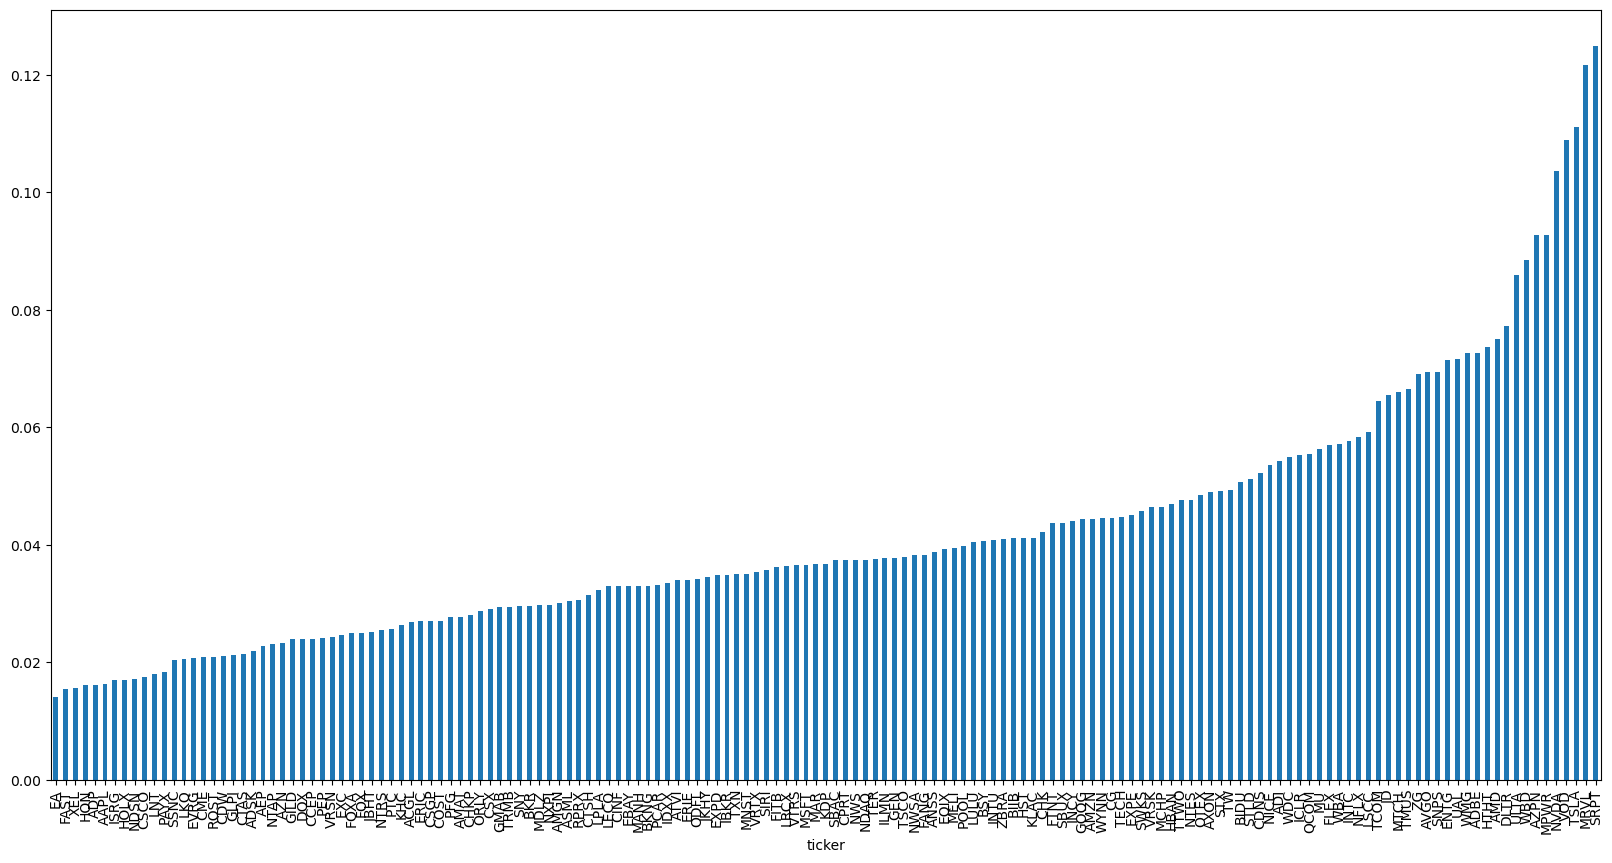

In [14]:
rmse_quality.plot.bar(figsize=(20,10))

In [15]:
result["zero"]=0

<AxesSubplot: >

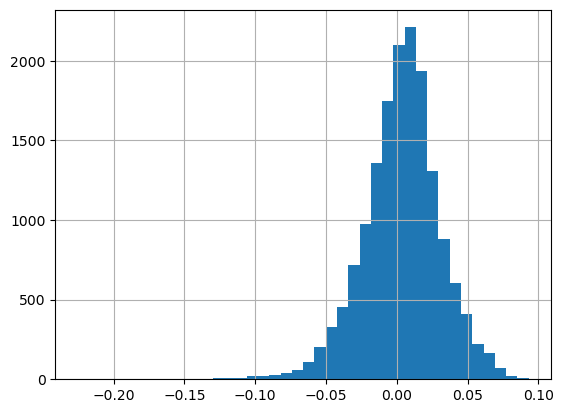

In [16]:
result.pred_step_0.hist(bins=40)

<AxesSubplot: >

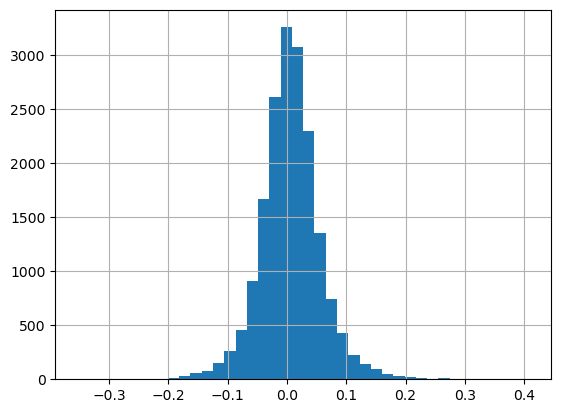

In [17]:
result.log_return_7.hist(bins=40)

In [18]:
result[(result.date==inference_date)&(result.pred_step_0>0)]

,date,ticker,industry,Close,holiday,dow,weekend,woy,working_day,i,...,woy_49,woy_50,woy_51,woy_52,dow_1,dow_2,dow_3,dow_4,pred_step_0,zero
122,2023-06-15,AAPL,NaN,NaN,no_holiday,3,0,24,1,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040717,0
268,2023-06-15,ACGL,NaN,NaN,no_holiday,3,0,24,1,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005556,0
414,2023-06-15,ADBE,NaN,NaN,no_holiday,3,0,24,1,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056108,0
560,2023-06-15,ADI,NaN,NaN,no_holiday,3,0,24,1,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031354,0
706,2023-06-15,ADP,NaN,NaN,no_holiday,3,0,24,1,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043149,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22460,2023-06-15,WMG,NaN,NaN,no_holiday,3,0,24,1,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.081639,0
22606,2023-06-15,WYNN,NaN,NaN,no_holiday,3,0,24,1,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006734,0
22752,2023-06-15,XEL,NaN,NaN,no_holiday,3,0,24,1,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030469,0
22898,2023-06-15,ZBRA,NaN,NaN,no_holiday,3,0,24,1,122.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039465,0


<AxesSubplot: xlabel='date'>

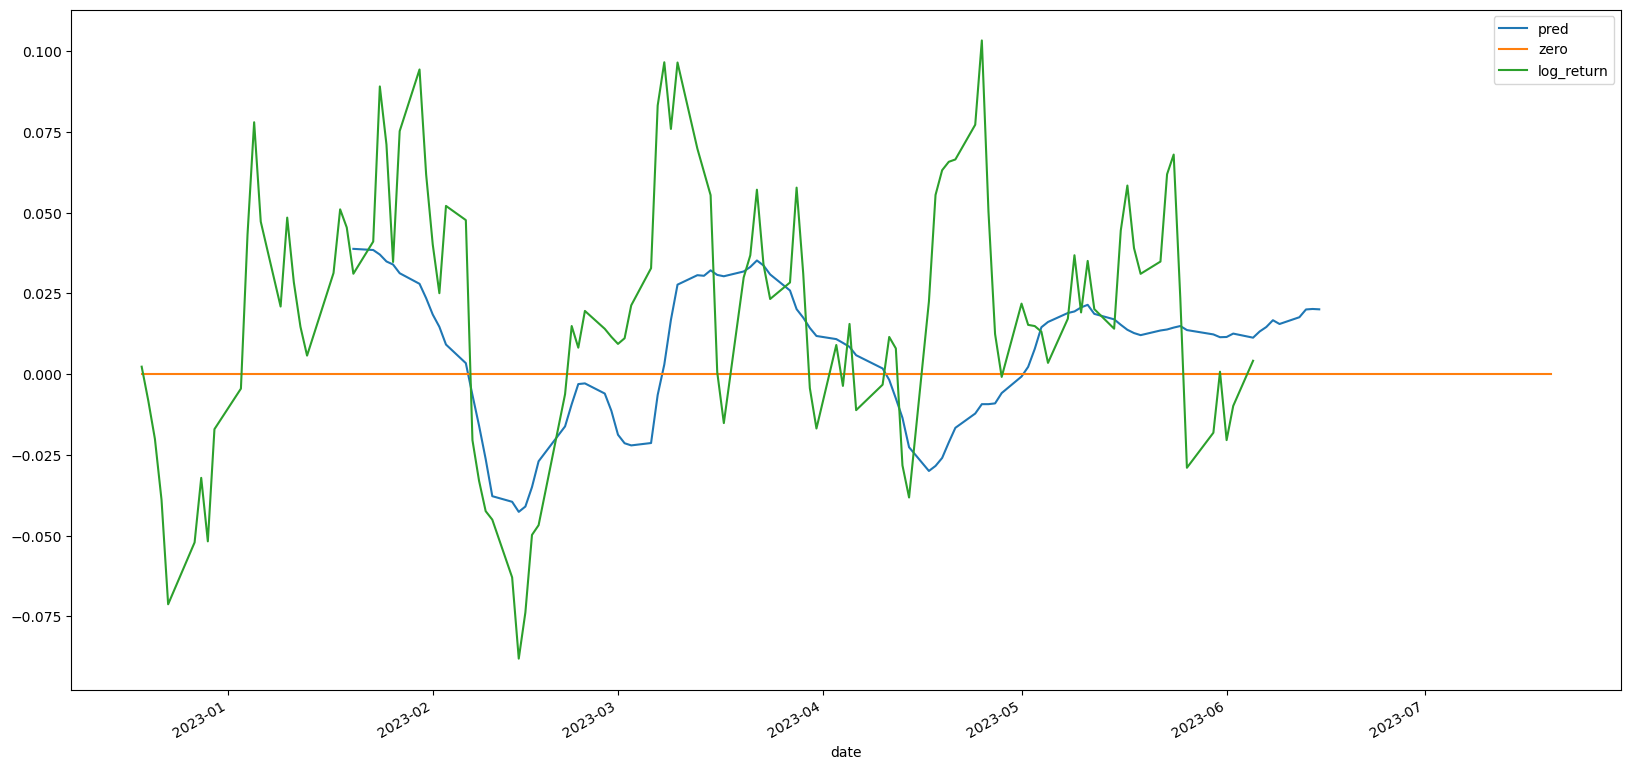

In [23]:
result[result.ticker=="MSFT"].groupby("date").agg(pred=("pred_step_0","mean"),zero=("zero","mean"),log_return=(TARGET,"mean")).plot(figsize=(20,10))

In [18]:
RISK_LEVEL=0.01

In [19]:
expected_price="Close_shift_-1"

In [20]:
## PREDICTED CLOSE FOR NEXT TRADING DAY
if not expected_price in result.columns:
    result=shift(result,lag=-1,column="Close")

In [21]:
import datetime
today=datetime.datetime.today()

In [22]:
#result=result[result.date<=today]

In [23]:
tickers=result.ticker.unique()

In [24]:
MIN_BUDGET=0
MAX_BUDGET=1000
CNT_EXPERIMENTS=10

----
## SIMULATION
----

<AxesSubplot: xlabel='date'>

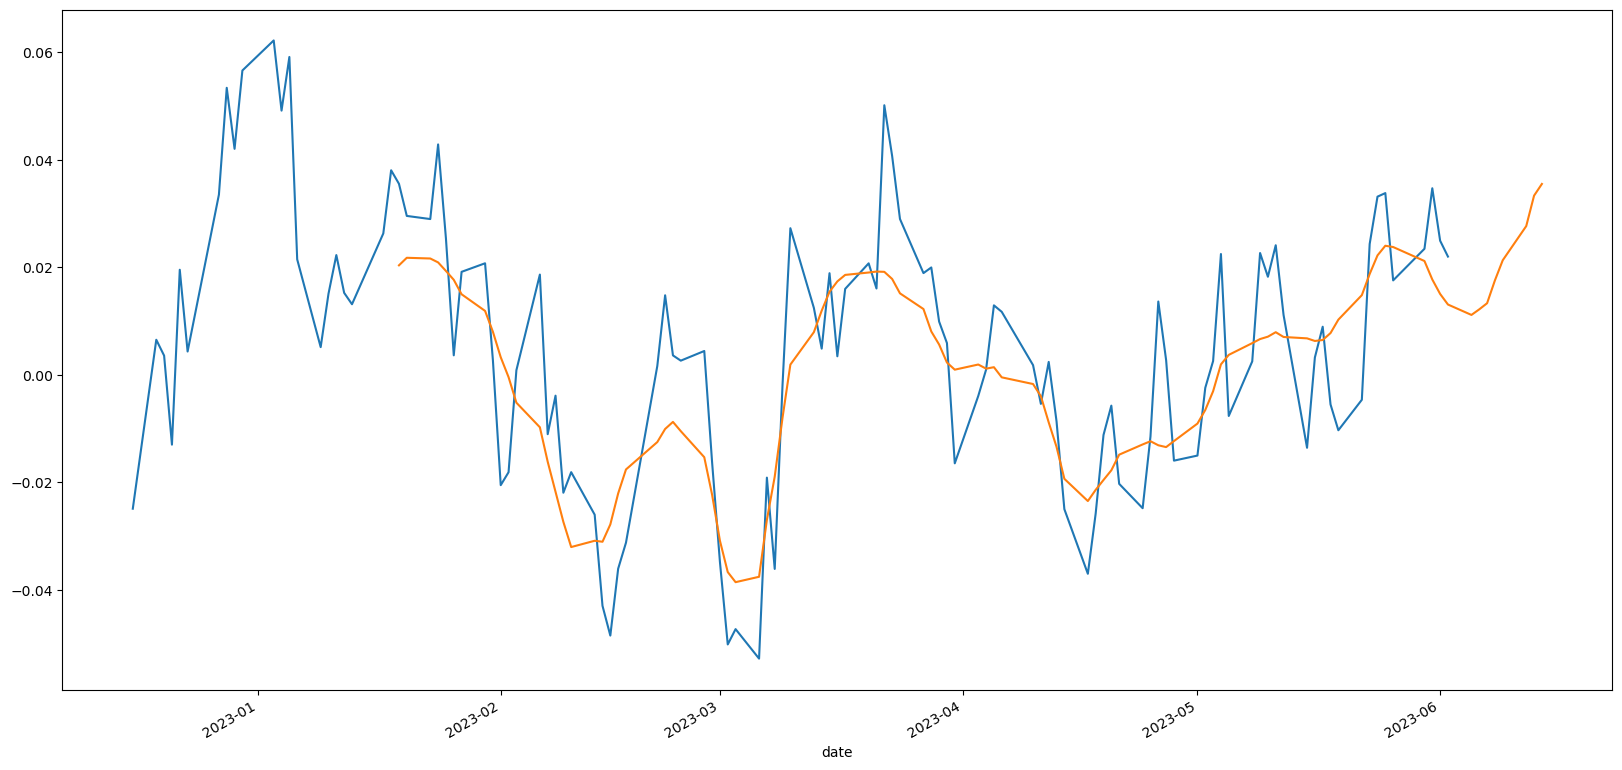

In [25]:
result.groupby("date").log_return_7.mean().plot(figsize=(20,10))
result.groupby("date").pred_step_0.mean().plot()

In [26]:
expected_price_col="Close_shift_-1"
expected_log_return_col="pred_step_0"
actual_price_col="Close"

In [27]:
CNT_EXPERIMENTS=50

In [28]:
from scipy.stats import norm as dist

In [29]:
dates=[]
actual_investments=[]
expected_investments=[]
values_at_risk=[]
predicted_returns=[]
actual_returns=[]
maturity_dates=[]
shares=[]
opt_results=[]
successful_opt=[]
for date in result[result.date<=inference_date].date.unique()[-CNT_EXPERIMENTS:]:
    opt_ticker,opt_shares,opt_success=maximise_returns(result=result,
                     date=date,
                     expected_price_col=expected_price_col,
                     expected_log_return_col=expected_log_return_col,
                     log_return_col=TARGET,
                     log_return_horizon=HORIZON,
                     min_expected_log_return=-.001,
                     max_value_at_risk=10,
                     confidence_level=.99,
                     max_budget=1000,
                     min_budget=0,
                     diversity=.2,
                    )
    successful_opt.append(opt_success)
    shares_date=pd.DataFrame(zip(opt_ticker,np.round(opt_shares,5)),columns=["ticker","share"])
    shares_date["date"]=date
    opt_results.append(shares_date)
    date_results=result[(result.ticker.isin(opt_ticker))&(result.date==date)]
    expected_prices=date_results[expected_price_col].to_numpy()
    expected_investment=portfolio_expected_investment(shares=opt_shares,prices=expected_prices)
    prices=date_results[actual_price_col].to_numpy()
    actual_investment=portfolio_expected_investment(shares=opt_shares,prices=prices)
    expected_log_returns=date_results[expected_log_return_col].to_numpy()
    log_returns=date_results[TARGET].to_numpy()
    
    z = dist.ppf(1 - .95)
    hist=get_historical_returns(data=result[result.ticker.isin(opt_ticker)],date=date,log_return_col=TARGET)
    value_at_risk=var(hist=hist,shares=opt_shares,prices=expected_prices,z=z)
    expected_return=portfolio_expected_return(shares=opt_shares,prices=expected_prices,log_returns=expected_log_returns)
    actual_return=portfolio_expected_return(shares=opt_shares,prices=prices,log_returns=log_returns)

    dates.append(date)
    actual_investments.append(actual_investment)
    expected_investments.append(expected_investment)
    values_at_risk.append(value_at_risk)
    predicted_returns.append(expected_return)
    actual_returns.append(actual_return)
    maturity_dates.append(result[result.date==date]["lag_date_Close_7"].unique()[0])

['AAPL' 'ACGL' 'ADBE' 'AEP' 'AMGN' 'ANSS' 'ATVI' 'AXON' 'AZN' 'AZPN'
 'BIIB' 'BKNG' 'BKR' 'BSY' 'CCEP' 'CDNS' 'CG' 'CHK' 'CHKP' 'CME' 'COST'
 'CPRT' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DLTR' 'EA' 'EQIX' 'EVRG' 'EXC' 'EXPD'
 'EXPE' 'FANG' 'FAST' 'FITB' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'HBAN'
 'HOLX' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTU'
 'ISRG' 'JBHT' 'JKHY' 'KDP' 'KHC' 'LKQ' 'LNT' 'LPLA' 'LULU' 'MANH' 'MAR'
 'MDLZ' 'MNST' 'MSFT' 'NDAQ' 'NDSN' 'NICE' 'NTES' 'NTRS' 'NWS' 'NWSA'
 'ODFL' 'ORLY' 'OTEX' 'PCAR' 'PEP' 'PFG' 'POOL' 'PTC' 'ROST' 'RPRX' 'SBAC'
 'SBUX' 'SIRI' 'SNY' 'STLD' 'TCOM' 'TECH' 'TMUS' 'TRMB' 'TSCO' 'TTWO' 'TW'
 'ULTA' 'VOD' 'VRSK' 'VRSN' 'VRTX' 'WBA' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.05238275553262683
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 50
     jac: [ 7.029e-02  2.534e-02 ...  1.362e-02  2.644e-02]
    nfev: 4948
    njev: 48
['AAPL' 'ACGL' 'ADBE' 'AEP' 'AMGN' 'ANSS' 'ATVI' 'AXON' 'AZN' 'AZPN'
 'BIIB' 'BKNG' 'BKR' 'BSY' 'CCEP' 'CDNS' 'CG' 'CHK' 'CHKP' 'CME' 'COST'
 'CPRT' 'CSGP' 'CSX' 'CTAS' 'DLTR' 'EA' 'EQIX' 'EVRG' 'EXC' 'EXPD' 'EXPE'
 'FANG' 'FAST' 'FITB' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'HBAN' 'HOLX'
 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTU' 'ISRG'
 'JBHT' 'KDP' 'KHC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LULU' 'MANH' 'MAR' 'MDLZ'
 'MNST' 'MSFT' 'NDAQ' 'NDSN' 'NICE' 'NTES' 'NTRS' 'ODFL' 'ORLY' 'OTEX'
 'PAYX' 'PCAR' 'PEP' 'PFG' 'POOL' 'PTC' 'ROST' 'RPRX' 'SBAC' 'SBUX' 'SNY'
 'SRPT' 'STLD' 'TCOM' 'TECH' 'TMUS' 'TRMB' 'TSCO' 'TTWO' 'TW' 'ULTA' 'VOD'
 'VRSK' 'VRSN' 'VRTX' 'WBA' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.04987966478362965
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 49
     jac: [ 6.211e-02  2.143e-02 ...  1.273e-02  2.626e-02]
    nfev: 4854
    njev: 48
['AAPL' 'ACGL' 'ADBE' 'AEP' 'AMGN' 'ATVI' 'AXON' 'AZN' 'BIIB' 'BKNG' 'BKR'
 'CCEP' 'CHK' 'CHKP' 'CME' 'COST' 'CPRT' 'CSGP' 'CSX' 'CTAS' 'DLTR' 'EA'
 'EQIX' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FTNT' 'GEN'
 'GILD' 'GLPI' 'GMAB' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR'
 'IDXX' 'ILMN' 'INCY' 'ISRG' 'JBHT' 'KDP' 'KHC' 'LECO' 'LKQ' 'LNT' 'LPLA'
 'LULU' 'MAR' 'MDLZ' 'MNST' 'MSFT' 'NDAQ' 'NDSN' 'NTES' 'NTRS' 'ODFL'
 'ORLY' 'PAYX' 'PCAR' 'PEP' 'PFG' 'POOL' 'ROST' 'RPRX' 'SBUX' 'SNY' 'SRPT'
 'STLD' 'TCOM' 'TECH' 'TMUS' 'TRMB' 'TSCO' 'TTWO' 'TW' 'ULTA' 'VOD' 'VRSK'
 'VRSN' 'VRTX' 'WBA' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.04490208997034895
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 41
     jac: [ 6.910e-02  2.064e-02 ...  1.671e-02  3.076e-02]
    nfev: 3602
    njev: 40
['AAPL' 'ACGL' 'ADBE' 'AEP' 'AMGN' 'AXON' 'AZN' 'BIIB' 'BKNG' 'BKR' 'CCEP'
 'CHK' 'CME' 'COST' 'CPRT' 'CSGP' 'CSX' 'CTAS' 'DLTR' 'EA' 'EQIX' 'EVRG'
 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'GEN' 'GILD' 'GLPI' 'GMAB'
 'HBAN' 'HOLX' 'HON' 'HST' 'IBKR' 'INCY' 'ISRG' 'JBHT' 'KDP' 'KHC' 'LECO'
 'LKQ' 'LNT' 'LPLA' 'LULU' 'MAR' 'MDLZ' 'MNST' 'NDAQ' 'NDSN' 'NTES' 'ODFL'
 'ORLY' 'PAYX' 'PCAR' 'PEP' 'POOL' 'ROST' 'RPRX' 'SBUX' 'SNY' 'SRPT'
 'STLD' 'TCOM' 'TECH' 'TMUS' 'TRMB' 'TSCO' 'TTWO' 'TW' 'ULTA' 'VOD' 'VRSK'
 'VRTX' 'WBA' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.041858024740803274
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 44
     jac: [ 4.601e-02  1.310e-02 ...  1.016e-02  2.149e-02]
    nfev: 3400
    njev: 43
['AAPL' 'ACGL' 'ADBE' 'AEP' 'AMGN' 'AXON' 'AZN' 'BIIB' 'BKNG' 'BKR' 'CCEP'
 'CHK' 'CME' 'COST' 'CPRT' 'CSGP' 'CSX' 'CTAS' 'DLTR' 'EA' 'EQIX' 'EVRG'
 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'GEN' 'GILD' 'GLPI' 'GMAB'
 'HBAN' 'HOLX' 'HON' 'IBKR' 'INCY' 'ISRG' 'JBHT' 'KDP' 'KHC' 'LECO' 'LKQ'
 'LNT' 'LPLA' 'LULU' 'MAR' 'MDLZ' 'MNST' 'NDAQ' 'NDSN' 'ODFL' 'ORLY'
 'PAYX' 'PCAR' 'PEP' 'ROST' 'RPRX' 'SBUX' 'SNY' 'SRPT' 'STLD' 'TCOM'
 'TECH' 'TMUS' 'TRMB' 'TSCO' 'TTWO' 'TW' 'ULTA' 'VOD' 'VRSK' 'VRTX' 'WBA'
 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.03801522876726776
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 40
     jac: [ 8.256e-02  2.229e-02 ...  2.234e-02  4.207e-02]
    nfev: 2966
    njev: 39
['AAPL' 'ACGL' 'AEP' 'AMGN' 'AZN' 'BIIB' 'BKNG' 'CCEP' 'COST' 'CPRT'
 'CSGP' 'CSX' 'CTAS' 'DLTR' 'EA' 'EQIX' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FAST'
 'FITB' 'GEN' 'GILD' 'GLPI' 'GMAB' 'HOLX' 'HON' 'INCY' 'ISRG' 'JBHT' 'KDP'
 'KHC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LULU' 'MAR' 'MDLZ' 'MNST' 'NDSN' 'ORLY'
 'PCAR' 'PEP' 'ROST' 'RPRX' 'SBUX' 'SNY' 'SRPT' 'STLD' 'TCOM' 'TECH'
 'TMUS' 'TRMB' 'TSCO' 'TTWO' 'TW' 'ULTA' 'VOD' 'VRSK' 'VRTX' 'WBA' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.037814735759275325
       x: [ 1.005e-10  1.001e-10 ...  1.001e-10  1.002e-10]
     nit: 41
     jac: [ 3.331e-01  8.470e-02 ...  1.006e-01  1.601e-01]
    nfev: 2604
    njev: 40
['AAPL' 'ACGL' 'AEP' 'AMGN' 'AZN' 'BIIB' 'BKNG' 'CCEP' 'COST' 'CPRT'
 'CSGP' 'CSX' 'DLTR' 'EQIX' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FAST' 'GILD'
 'GLPI' 'HOLX' 'HON' 'ISRG' 'JBHT' 'KDP' 'KHC' 'LECO' 'LKQ' 'LNT' 'LULU'
 'MDLZ' 'MNST' 'ORLY' 'PCAR' 'PEP' 'ROST' 'RPRX' 'SBUX' 'SNY' 'STLD'
 'TCOM' 'TECH' 'TMUS' 'TRMB' 'TSCO' 'ULTA' 'VOD' 'VRSK' 'XEL']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.035809145559990825
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 51
     jac: [ 7.881e-02  2.032e-02 ...  5.183e-02  3.962e-02]
    nfev: 2567
    njev: 50
['ACGL' 'AZN' 'BKNG' 'CCEP' 'COST' 'CSGP' 'CSX' 'EVRG' 'GILD' 'HON' 'ISRG'
 'KDP' 'LECO' 'LKQ' 'LNT' 'MNST' 'ORLY' 'PCAR' 'PEP' 'SNY' 'STLD' 'TCOM'
 'TECH' 'TMUS' 'TRMB' 'TSCO' 'ULTA' 'VOD' 'VRSK']
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.03197902885208255
       x: [ 1.012e-10  1.009e-10 ...  1.574e+00  1.020e-10]
     nit: 43
     jac: [ 7.093e-02  1.269e-01 ...  1.444e-08  1.875e-01]
    nfev: 1264
    njev: 42
['ACGL' 'BKNG' 'CCEP' 'CSX' 'ISRG' 'KDP' 'LECO' 'LKQ' 'MNST' 'ORLY' 'PEP'
 'TCOM' 'TRMB' 'TSCO' 'ULTA' 'VOD' 'VRSK']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.027906418552458817
       x: [ 1.000e-10  1.000e-10 ...  1.753e+00  1.000e-10]
     nit: 42
     jac: [ 7.599e-02  3.691e+00 ...  0.000e+00  1.571e-01]
    nfev: 724
    njev: 40
['ACGL' 'CCEP' 'CSX' 'ENTG' 'ISRG' 'KDP' 'LECO' 'LKQ' 'MNST' 'ORLY' 'PEP'
 'TRMB' 'TSCO' 'ULTA' 'VOD' 'VRSK']
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.021777446727790584
       x: [ 1.000e-10  1.000e-10 ...  1.366e+00  1.000e-10]
     nit: 30
     jac: [ 1.951e-02  1.210e-02 ... -5.484e-04  2.860e-02]
    nfev: 495
    njev: 29
['CCEP' 'CSGP' 'ENTG' 'ISRG' 'KDP' 'LECO' 'LKQ' 'LRCX' 'MNST' 'ORLY' 'PEP'
 'TER' 'TRMB' 'TSCO' 'ULTA' 'VOD' 'VRSK']
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.01970150630335584
       x: [ 1.000e-10  1.000e-10 ...  1.376e+00  1.000e-10]
     nit: 30
     jac: [ 1.076e-02  1.671e-02 ... -3.252e-04  2.450e-02]
   

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.017793339775567504
       x: [ 1.000e-10  1.000e-10 ...  2.710e+00  1.000e-10]
     nit: 38
     jac: [ 1.813e-02  1.133e-01 ... -2.462e-04  1.878e-02]
    nfev: 666
    njev: 37
['ADSK' 'AMAT' 'ASML' 'CCEP' 'CSGP' 'EBAY' 'ENTG' 'FAST' 'INTC' 'INTU'
 'ISRG' 'JD' 'KDP' 'KHC' 'LECO' 'LKQ' 'LRCX' 'MNST' 'MRVL' 'MU' 'NXPI'
 'PEP' 'POOL' 'QCOM' 'SSNC' 'STLD' 'SWKS' 'TER' 'TRMB' 'VOD' 'VRSK']
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.018864955974239078
       x: [ 1.000e-10  1.000e-10 ...  1.161e+00  1.000e-10]
     nit: 40
     jac: [ 4.718e-02  2.272e-02 ...  2.008e-05  2.508e-02]
    nfev: 1248
    njev: 39
['AAPL' 'ADSK' 'AMAT' 'AMD' 'AMZN' 'ASML' 'CCEP' 'CSGP' 'EBAY' 'ENTG'
 'FAST' 'GOOG' 'HST' 'INTC' 'INTU' 'ISRG' 'JD' 'KDP' 'KHC' 'KLAC' 'LECO'
 'LRCX' 'MNST' 'MRVL' 'MTCH' 'MU' 'NXPI' 'PEP' 'POOL' 'QCOM' 'SSNC' 'STLD'
 'SWKS' 'TER' 'TRMB' 'VOD' 'VRSK' 'ZG'

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.02155397108364115
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 40
     jac: [ 4.850e-02  5.228e-02 ...  3.544e-02  1.024e-02]
    nfev: 1524
    njev: 39
['AAPL' 'AMAT' 'AMD' 'AMZN' 'ASML' 'CCEP' 'CPRT' 'CSGP' 'EBAY' 'ENTG'
 'FAST' 'GOOG' 'HST' 'INTC' 'ISRG' 'JD' 'KDP' 'KHC' 'KLAC' 'LECO' 'LRCX'
 'MNST' 'MRVL' 'MTCH' 'MU' 'NTAP' 'NXPI' 'PEP' 'POOL' 'QCOM' 'STLD' 'SWKS'
 'TER' 'TRMB' 'TXN' 'VOD' 'VRSK' 'WDC' 'ZG']
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.02239517332594039
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 39
     jac: [ 4.578e-02  1.682e-02 ...  8.982e-03  8.784e-03]
    nfev: 1524
    njev: 38
['AAPL' 'ACGL' 'AMAT' 'AMD' 'AMZN' 'ASML' 'CCEP' 'CPRT' 'CSGP' 'EBAY'
 'ENTG' 'GOOG' 'HST' 'INTC' 'ISRG' 'JD' 'KDP' 'KLAC' 'LECO' 'LRCX' 'MPWR'
 'MRVL' 'MTCH' 'MU' 'NTAP' 'NXPI' 'PEP' 'POOL' 'QCOM' 'STLD' 

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.023139491608112517
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 33
     jac: [ 5.143e-02  2.236e-02 ...  9.328e-03  9.158e-03]
    nfev: 1248
    njev: 32
['AAPL' 'ACGL' 'AMAT' 'AMD' 'AMZN' 'ASML' 'CCEP' 'CPRT' 'CSGP' 'CTAS'
 'EBAY' 'ENTG' 'GOOG' 'HST' 'INTC' 'JD' 'KDP' 'KLAC' 'LECO' 'LRCX' 'MNST'
 'MPWR' 'MRVL' 'MTCH' 'MU' 'NTAP' 'NVDA' 'NXPI' 'PEP' 'POOL' 'QCOM' 'STLD'
 'SWKS' 'TER' 'TRMB' 'TXN' 'VOD' 'VRSK' 'WDC' 'ZG']
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.023541415019078926
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 40
     jac: [ 5.130e-02  2.124e-02 ...  9.504e-03  9.574e-03]
    nfev: 1603
    njev: 39
['AAPL' 'ACGL' 'AMAT' 'AMD' 'AMZN' 'ASML' 'AVGO' 'CCEP' 'CPRT' 'CSGP'
 'CTAS' 'EBAY' 'ENTG' 'GOOG' 'HST' 'INTC' 'JD' 'KDP' 'KLAC' 'LECO' 'LRCX'
 'MCHP' 'MNST' 'MPWR' 'MRVL' 'MTCH' 'MU' 'NTAP' 'NV

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.024832123394291267
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 40
     jac: [ 5.420e-02  2.217e-02 ...  9.397e-03  1.122e-02]
    nfev: 1762
    njev: 39
['AAPL' 'ACGL' 'ADI' 'AMAT' 'AMD' 'AMZN' 'ASML' 'AVGO' 'CCEP' 'COST'
 'CPRT' 'CSGP' 'CTAS' 'EBAY' 'ENTG' 'FAST' 'FLEX' 'GOOG' 'HST' 'INTC' 'JD'
 'KDP' 'KLAC' 'LECO' 'LRCX' 'MCHP' 'MNST' 'MPWR' 'MRVL' 'MTCH' 'MU' 'NTAP'
 'NVDA' 'NXPI' 'PEP' 'POOL' 'QCOM' 'STLD' 'STX' 'SWKS' 'TER' 'TMUS' 'TRMB'
 'TTWO' 'TXN' 'VOD' 'VRSK' 'WBA' 'WDC' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.03161839379104134
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 49
     jac: [ 7.452e-02  3.327e-02 ...  1.372e-02  1.593e-02]
    nfev: 2458
    njev: 48
['AAPL' 'ACGL' 'ADI' 'AMAT' 'AMD' 'AMZN' 'ASML' 'AVGO' 'BIDU' 'CCEP'
 'COST' 'CPRT' 'CSGP' 'CTAS' 'DOX' 'EA' 'EBAY' 'ENTG' 'EXPE' 'FAST' 'FLEX'
 'FTNT' 'GOOG' 'HST' 'INTC' 'ISRG' 'JD' 'KDP' 'KLAC' 'LECO' 'LRCX' 'MCHP'
 'MDLZ' 'MNST' 'MPWR' 'MRVL' 'MTCH' 'MU' 'NTAP' 'NVDA' 'NXPI' 'PCAR' 'PEP'
 'POOL' 'QCOM' 'SNPS' 'STLD' 'STX' 'SWKS' 'TER' 'TMUS' 'TRMB' 'TTWO' 'TXN'
 'VOD' 'VRSK' 'VRSN' 'WBA' 'WDC' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.038290066801961516
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 41
     jac: [ 8.965e-02  4.054e-02 ...  1.694e-02  1.857e-02]
    nfev: 2442
    njev: 40
['AAPL' 'ACGL' 'ADI' 'ADSK' 'AMAT' 'AMD' 'AMZN' 'ASML' 'AVGO' 'BIDU' 'BSY'
 'CCEP' 'CHK' 'CHKP' 'COST' 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'DLTR' 'DOX'
 'EA' 'EBAY' 'ENTG' 'EXPE' 'FLEX' 'FTNT' 'GOOG' 'HST' 'ICLR' 'IDXX' 'ILMN'
 'INTC' 'INTU' 'ISRG' 'JD' 'KDP' 'KLAC' 'LECO' 'LRCX' 'LSCC' 'MCHP' 'MDLZ'
 'MELI' 'MNST' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NTAP' 'NVDA' 'NWS' 'NWSA'
 'NXPI' 'PAYX' 'PCAR' 'PEP' 'POOL' 'QCOM' 'SIRI' 'SNPS' 'SSNC' 'STLD'
 'STX' 'SWKS' 'TCOM' 'TER' 'TMUS' 'TRMB' 'TTWO' 'TXN' 'VOD' 'VRSK' 'VRSN'
 'WBA' 'WDC' 'ZBRA' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.04673499652127537
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 44
     jac: [ 1.119e-01  5.356e-02 ...  1.758e-01  2.157e-02]
    nfev: 3515
    njev: 43
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AVGO' 'BIDU' 'BIIB' 'BKNG' 'BSY' 'CCEP' 'CDW' 'CHK' 'CHKP'
 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'DLTR' 'DOX' 'EA' 'EBAY'
 'ENTG' 'ERIC' 'EXPE' 'FANG' 'FAST' 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN'
 'GOOG' 'HST' 'ICLR' 'IDXX' 'ILMN' 'INTC' 'INTU' 'ISRG' 'JD' 'JKHY' 'KDP'
 'KLAC' 'LECO' 'LPLA' 'LRCX' 'LSCC' 'MANH' 'MCHP' 'MDLZ' 'MELI' 'MNST'
 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NFLX' 'NICE' 'NTAP' 'NTES'
 'NVDA' 'NWS' 'NWSA' 'NXPI' 'OTEX' 'PAYX' 'PCAR' 'PEP' 'POOL' 'PTC' 'QCOM'
 'SIRI' 'SNPS' 'SSNC' 'STLD' 'STX' 'SWKS' 'TCOM' 'TER' 'TMUS' 'TRMB'
 'TTWO' 'TW' 'TXN' 'VOD' 'VRSK' 'VRSN' 'WBA' 'WBD' 'WDC' 'WMG' 'ZBRA' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.053832877175330814
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 46
     jac: [ 1.296e-01  6.062e-02 ...  1.932e-01  2.159e-02]
    nfev: 4755
    njev: 44
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AVGO' 'BIDU' 'BIIB' 'BKNG' 'BSY' 'CCEP' 'CDW' 'CHK' 'CHKP'
 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA'
 'EBAY' 'ENTG' 'ERIC' 'EXPE' 'FANG' 'FAST' 'FLEX' 'FOX' 'FOXA' 'FTNT'
 'GEN' 'GOOG' 'HST' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INTC' 'INTU' 'ISRG' 'JD'
 'JKHY' 'KDP' 'KLAC' 'LECO' 'LPLA' 'LRCX' 'LSCC' 'MANH' 'MCHP' 'MDLZ'
 'MELI' 'MNST' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NFLX' 'NICE'
 'NTAP' 'NTES' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'OTEX' 'PAYX' 'PCAR' 'PEP'
 'POOL' 'PTC' 'QCOM' 'SIRI' 'SNPS' 'SSNC' 'STLD' 'STX' 'SWKS' 'TCOM' 'TER'
 'TMUS' 'TRMB' 'TTWO' 'TW' 'TXN' 'VOD' 'VRSK' 'VRSN' 'WBA' 'WBD' 'WDC'
 'WMG' 'ZBRA

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.05903498488402241
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 43
     jac: [ 1.451e-01  6.639e-02 ...  2.172e-01  2.298e-02]
    nfev: 4514
    njev: 41
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AVGO' 'BIDU' 'BIIB' 'BKNG' 'BSY' 'CCEP' 'CDW' 'CHK' 'CHKP'
 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA'
 'EBAY' 'ENTG' 'ERIC' 'EXPE' 'FANG' 'FAST' 'FLEX' 'FOX' 'FOXA' 'FTNT'
 'GEN' 'GOOG' 'HST' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INTC' 'INTU' 'ISRG' 'JD'
 'JKHY' 'KDP' 'KLAC' 'LECO' 'LPLA' 'LRCX' 'LSCC' 'MANH' 'MCHP' 'MDLZ'
 'MELI' 'MNST' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NFLX' 'NICE'
 'NTAP' 'NTES' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'OTEX' 'PAYX' 'PCAR' 'PEP'
 'POOL' 'PTC' 'QCOM' 'SIRI' 'SNPS' 'SSNC' 'STLD' 'STX' 'SWKS' 'TCOM' 'TER'
 'TMUS' 'TRMB' 'TTWO' 'TW' 'TXN' 'VOD' 'VRSK' 'VRSN' 'WBA' 'WBD' 'WDC'
 'WMG' 'ZBRA' 'ZG']

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.0630051848407564
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 45
     jac: [ 1.663e-01  7.559e-02 ...  2.302e-01  2.067e-02]
    nfev: 4690
    njev: 43
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AVGO' 'BIDU' 'BIIB' 'BKNG' 'BSY' 'CDW' 'CG' 'CHK' 'CHKP'
 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DOX' 'EA' 'EBAY'
 'ENTG' 'ERIC' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT'
 'GEN' 'GOOG' 'HBAN' 'HST' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INTC' 'INTU'
 'ISRG' 'JD' 'JKHY' 'KDP' 'KLAC' 'LECO' 'LPLA' 'LRCX' 'LSCC' 'MANH' 'MCHP'
 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NFLX' 'NICE' 'NTAP'
 'NTES' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'OTEX' 'PAYX' 'PCAR' 'POOL' 'PTC'
 'QCOM' 'SIRI' 'SNPS' 'SSNC' 'STLD' 'STX' 'SWKS' 'TCOM' 'TECH' 'TER'
 'TMUS' 'TRMB' 'TTWO' 'TW' 'TXN' 'VOD' 'VRSK' 'VRSN' 'WBA' 'WBD' 'WDC'
 'WMG' 'ZBRA' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06549834170446213
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 37
     jac: [ 1.788e-01  8.245e-02 ...  2.409e-01  1.765e-02]
    nfev: 3892
    njev: 36
['AAPL' 'ADBE' 'ADI' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS' 'ASML'
 'ATVI' 'AVGO' 'BIDU' 'BIIB' 'BKNG' 'BSY' 'CDW' 'CG' 'CHK' 'CHKP' 'CME'
 'COST' 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DOX' 'EA' 'EBAY' 'ENTG'
 'ERIC' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN'
 'GOOG' 'HBAN' 'HST' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INTC' 'INTU' 'ISRG' 'JD'
 'JKHY' 'KDP' 'KLAC' 'LECO' 'LPLA' 'LRCX' 'LSCC' 'MANH' 'MCHP' 'MELI'
 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NFLX' 'NICE' 'NTAP' 'NTES'
 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'OTEX' 'PAYX' 'PFG' 'POOL' 'PTC' 'QCOM'
 'RPRX' 'SBUX' 'SIRI' 'SNPS' 'SSNC' 'STLD' 'STX' 'SWKS' 'TCOM' 'TECH'
 'TER' 'TMUS' 'TRMB' 'TTWO' 'TW' 'TXN' 'VOD' 'VRSK' 'VRSN' 'WBA' 'WBD'
 'WDC' 'WMG' 'ZBRA' 

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06586728177028373
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 41
     jac: [ 1.870e-01  3.136e-01 ...  2.433e-01  1.586e-02]
    nfev: 4403
    njev: 40
['AAPL' 'ADBE' 'ADI' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS' 'ASML'
 'ATVI' 'AVGO' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR' 'BSY' 'CDW' 'CG' 'CHK'
 'CHKP' 'CINF' 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DOX'
 'EA' 'EBAY' 'ENTG' 'ERIC' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA'
 'FTNT' 'GEN' 'GOOG' 'HBAN' 'HST' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INTC'
 'INTU' 'ISRG' 'JD' 'JKHY' 'KDP' 'KLAC' 'LECO' 'LPLA' 'LRCX' 'LSCC' 'MANH'
 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NFLX' 'NICE'
 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'OTEX' 'PAYX' 'PCAR'
 'PFG' 'POOL' 'PTC' 'QCOM' 'RPRX' 'SBUX' 'SIRI' 'SNPS' 'SSNC' 'STLD' 'STX'
 'SWKS' 'TCOM' 'TECH' 'TER' 'TMUS' 'TRMB' 'TTWO' 'TW' 'TXN' 'VOD' 'VRSK'
 'VRSN' 'WBA

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06529656698153372
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 41
     jac: [ 1.940e-01  3.015e-01 ...  2.454e-01  1.461e-02]
    nfev: 4563
    njev: 40
['AAPL' 'ADBE' 'ADI' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS' 'ASML'
 'ATVI' 'AVGO' 'AZPN' 'BIDU' 'BKR' 'BSY' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF'
 'COST' 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DOX' 'EA' 'EBAY' 'ENTG'
 'ERIC' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN'
 'GOOG' 'HBAN' 'HST' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INTC' 'INTU' 'ISRG' 'JD'
 'JKHY' 'KDP' 'KLAC' 'LECO' 'LPLA' 'LRCX' 'LSCC' 'MANH' 'MCHP' 'MELI'
 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS'
 'NVDA' 'NWS' 'NWSA' 'NXPI' 'OTEX' 'PAYX' 'PFG' 'POOL' 'PTC' 'QCOM' 'SBAC'
 'SBUX' 'SIRI' 'SNPS' 'SSNC' 'STLD' 'STX' 'SWKS' 'TCOM' 'TER' 'TMUS'
 'TRMB' 'TTWO' 'TW' 'TXN' 'VOD' 'VRSK' 'VRSN' 'WBA' 'WBD' 'WDC' 'WMG'
 'ZBRA' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06325386306275253
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 42
     jac: [ 1.900e-01  2.776e-01 ...  2.287e-01  1.208e-02]
    nfev: 4429
    njev: 41
['AAPL' 'ADBE' 'ADI' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS' 'ASML'
 'ATVI' 'AVGO' 'AZPN' 'BIDU' 'BKR' 'BSY' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF'
 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DOX' 'EA' 'EBAY' 'ENTG' 'ERIC'
 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GOOG'
 'HBAN' 'HST' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INTC' 'INTU' 'JD' 'JKHY' 'KDP'
 'KLAC' 'LECO' 'LPLA' 'LRCX' 'LSCC' 'MANH' 'MCHP' 'MELI' 'MPWR' 'MRVL'
 'MSFT' 'MTCH' 'MU' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS'
 'NWSA' 'NXPI' 'OTEX' 'PFG' 'POOL' 'PTC' 'QCOM' 'SBAC' 'SBUX' 'SIRI'
 'SNPS' 'SSNC' 'STLD' 'STX' 'SWKS' 'TCOM' 'TER' 'TMUS' 'TRMB' 'TTWO' 'TW'
 'TXN' 'VOD' 'VRSK' 'VRSN' 'WBA' 'WBD' 'WDC' 'WMG' 'ZBRA' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06101813008621329
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 39
     jac: [ 1.863e-01  2.567e-01 ...  2.309e-01  1.535e-02]
    nfev: 4031
    njev: 38
['AAPL' 'ADBE' 'ADI' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS' 'ASML'
 'ATVI' 'AVGO' 'AZPN' 'BIDU' 'BKR' 'BSY' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF'
 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DOX' 'EA' 'EBAY' 'ENTG' 'ERIC'
 'EXPE' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GOOG' 'HBAN' 'HST'
 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INTC' 'INTU' 'JD' 'JKHY' 'KDP' 'KLAC' 'LECO'
 'LPLA' 'LRCX' 'LSCC' 'MANH' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH'
 'MU' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI'
 'OTEX' 'PFG' 'POOL' 'PTC' 'QCOM' 'SBAC' 'SBUX' 'SIRI' 'SNPS' 'SSNC'
 'STLD' 'STX' 'SWKS' 'TCOM' 'TER' 'TMUS' 'TRMB' 'TTWO' 'TW' 'TXN' 'VOD'
 'VRSK' 'VRSN' 'WBA' 'WBD' 'WDC' 'WMG' 'ZBRA' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.057995867841928055
       x: [ 1.064e-10  1.091e-10 ...  1.084e-10  1.008e-10]
     nit: 43
     jac: [ 1.696e-01  2.287e-01 ...  2.183e-01  1.705e-02]
    nfev: 4411
    njev: 42
['AAPL' 'ADBE' 'ADI' 'ADSK' 'AMAT' 'AMD' 'AMZN' 'ANSS' 'ASML' 'ATVI'
 'AVGO' 'AZPN' 'BIDU' 'BKR' 'BSY' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CPRT'
 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DOX' 'EA' 'EBAY' 'ENTG' 'ERIC' 'EXPE'
 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GOOG' 'HBAN' 'IBKR'
 'ICLR' 'IDXX' 'ILMN' 'INTC' 'INTU' 'JD' 'JKHY' 'KDP' 'KLAC' 'LECO' 'LPLA'
 'LRCX' 'LSCC' 'MANH' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU'
 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI'
 'OTEX' 'PAYX' 'PCAR' 'PFG' 'POOL' 'PTC' 'QCOM' 'SBAC' 'SBUX' 'SIRI'
 'SNPS' 'SSNC' 'STLD' 'STX' 'SWKS' 'TCOM' 'TER' 'TMUS' 'TRMB' 'TSLA'
 'TTWO' 'TW' 'TXN' 'VOD' 'VRSK' 'VRSN' 'WBA' 'WBD' 'WDC' 'WMG' 'ZBRA' 'ZG']


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.0556504708254837
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 45
     jac: [ 1.738e-01  2.157e-01 ...  2.256e-01  1.893e-02]
    nfev: 4666
    njev: 44
['AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AMAT' 'AMD' 'AMZN' 'ANSS' 'ASML' 'ATVI'
 'AVGO' 'AZPN' 'BIDU' 'BKR' 'BSY' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF'
 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX'
 'ERIC' 'EXPE' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GLPI'
 'GOOG' 'HBAN' 'HST' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INTC' 'INTU' 'JBHT' 'JD'
 'JKHY' 'KDP' 'KLAC' 'LECO' 'LPLA' 'LRCX' 'LSCC' 'MANH' 'MCHP' 'MELI'
 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES'
 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'OTEX' 'PAYX' 'PCAR' 'PFG' 'POOL' 'PTC'
 'QCOM' 'SBAC' 'SBUX' 'SIRI' 'SNPS' 'SSNC' 'STLD' 'STX' 'SWKS' 'TCOM'
 'TER' 'TMUS' 'TRMB' 'TSLA' 'TTWO' 'TW' 'TXN' 'VOD' 'VRSK' 'VRSN' 'WBA'
 'WBD' 'WDC' '

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.05374734155129292
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 51
     jac: [ 1.371e-01  1.674e-01 ...  1.888e-01  1.715e-02]
    nfev: 5601
    njev: 50
['AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AMAT' 'AMD' 'AMZN' 'ANSS' 'ASML' 'ATVI'
 'AVGO' 'AZPN' 'BIDU' 'BKNG' 'BKR' 'BSY' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP'
 'CINF' 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DOX' 'EA' 'EBAY' 'ENTG'
 'EQIX' 'ERIC' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT'
 'GEN' 'GLPI' 'GOOG' 'HBAN' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN'
 'INTC' 'INTU' 'JBHT' 'JD' 'JKHY' 'KDP' 'KLAC' 'LECO' 'LPLA' 'LRCX' 'LSCC'
 'MANH' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDSN' 'NFLX'
 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'OTEX'
 'PAYX' 'PCAR' 'PFG' 'POOL' 'PTC' 'QCOM' 'SBAC' 'SBUX' 'SIRI' 'SNPS'
 'SSNC' 'STLD' 'STX' 'SWKS' 'TCOM' 'TER' 'TMUS' 'TRMB' 'TSLA' 'TTWO' 'TW'
 'TXN' 'VOD

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.057573146719611744
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 54
     jac: [ 2.676e-01  3.411e-01 ...  3.995e-01  3.183e-02]
    nfev: 6138
    njev: 52
['AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS' 'ASML'
 'ATVI' 'AVGO' 'AZPN' 'BIDU' 'BKNG' 'BKR' 'BSY' 'CDNS' 'CDW' 'CG' 'CHK'
 'CHKP' 'CINF' 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DOX'
 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'EVRG' 'EXPD' 'EXPE' 'FANG' 'FAST'
 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GLPI' 'GOOG' 'HBAN' 'HON' 'HST'
 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INTC' 'INTU' 'JBHT' 'JD' 'JKHY' 'KDP'
 'KLAC' 'LECO' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'MANH' 'MAR' 'MCHP' 'MELI'
 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP'
 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'OTEX' 'PAYX' 'PCAR'
 'PFG' 'POOL' 'PTC' 'QCOM' 'SBAC' 'SBUX' 'SIRI' 'SNPS' 'SSNC' 'STLD' 'STX'
 'SWKS' 'T

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06242980927620532
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 59
     jac: [ 1.786e-01  2.504e-01 ...  2.985e-01  2.168e-02]
    nfev: 7239
    njev: 57
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZPN' 'BIDU' 'BKNG' 'BKR' 'BSY'
 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP'
 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'ERIE'
 'EVRG' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX' 'FOX' 'FOXA' 'FTNT'
 'GEN' 'GLPI' 'GOOG' 'HBAN' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN'
 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP' 'KHC' 'KLAC' 'LECO'
 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH' 'MAR' 'MCHP' 'MELI' 'MPWR'
 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES'
 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'ORLY' 'OTEX' 'PAYX' 'PCAR'
 'PEP' 'PFG

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.0642003317197691
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 71
     jac: [ 1.597e-01  9.867e-02 ...  2.778e-01  1.514e-02]
    nfev: 9937
    njev: 69
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR'
 'BSY' 'CCEP' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CPRT'
 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX'
 'ERIC' 'ERIE' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX'
 'FOX' 'FOXA' 'FTNT' 'GEN' 'GLPI' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT'
 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD'
 'JKHY' 'KDP' 'KHC' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU'
 'MANH' 'MAR' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN'
 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL'
 'ORLY' 'OTEX

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06475568901152425
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 64
     jac: [ 1.551e-01  9.841e-02 ...  2.753e-01  9.059e-03]
    nfev: 9206
    njev: 62
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR'
 'BSY' 'CCEP' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CPRT'
 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX'
 'ERIC' 'ERIE' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX'
 'FOX' 'FOXA' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON'
 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG'
 'JBHT' 'JD' 'JKHY' 'KDP' 'KHC' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX'
 'LSCC' 'LULU' 'MANH' 'MAR' 'MCHP' 'MDLZ' 'MELI' 'MNST' 'MPWR' 'MRVL'
 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS'
 'NVDA' 'NWS' 'NWS

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.0708223128362562
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 62
     jac: [ 1.535e-01  8.568e-02 ...  2.512e-01  9.369e-03]
    nfev: 9363
    njev: 60
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR'
 'BSY' 'CCEP' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CPRT'
 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX'
 'ERIC' 'ERIE' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FLEX'
 'FOX' 'FOXA' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON'
 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG'
 'JBHT' 'JD' 'JKHY' 'KDP' 'KHC' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX'
 'LSCC' 'LULU' 'MANH' 'MAR' 'MCHP' 'MDLZ' 'MELI' 'MNST' 'MPWR' 'MRVL'
 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS'
 'NVDA' 'NWS' 'NWSA

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.07576341160930342
       x: [ 1.001e-10  1.001e-10 ...  1.002e-10  1.000e-10]
     nit: 58
     jac: [ 1.783e-01  9.357e-02 ...  2.774e-01  1.126e-02]
    nfev: 8837
    njev: 57
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZN' 'AZPN' 'BIDU' 'BIIB' 'BKNG'
 'BKR' 'BSY' 'CCEP' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST'
 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG'
 'EQIX' 'ERIC' 'ERIE' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB'
 'FLEX' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN'
 'HOLX' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC'
 'INTU' 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP' 'KHC' 'KLAC' 'LECO' 'LKQ' 'LNT'
 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH' 'MAR' 'MCHP' 'MDLZ' 'MELI' 'MNST'
 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP'
 'NTES' 'NTRS' 'NVDA' 'NWS

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.0739441021857638
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 52
     jac: [ 1.867e-01  8.765e-02 ...  2.842e-01  1.245e-02]
    nfev: 7868
    njev: 51
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZN' 'AZPN' 'BIDU' 'BIIB' 'BKNG'
 'BKR' 'BSY' 'CCEP' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST'
 'CPRT' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG'
 'EQIX' 'ERIC' 'ERIE' 'EVRG' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FOX'
 'FOXA' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT'
 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD'
 'JKHY' 'KDP' 'KHC' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU'
 'MANH' 'MAR' 'MCHP' 'MELI' 'MNST' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ'
 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI'
 'ODFL' 'ORLY

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06949706045956641
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 68
     jac: [ 1.920e-01  8.424e-02 ...  2.912e-01  1.433e-02]
    nfev: 9836
    njev: 66
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AVGO' 'AXON' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR'
 'BSY' 'CCEP' 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CSCO'
 'CSGP' 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC'
 'ERIE' 'EVRG' 'EXPD' 'EXPE' 'FAST' 'FITB' 'FOX' 'FOXA' 'FTNT' 'GEN'
 'GILD' 'GLPI' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR'
 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP' 'KLAC' 'LECO'
 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH' 'MAR' 'MCHP' 'MELI' 'MNST'
 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP'
 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'ORLY' 'OTEX' 'PAYX'
 'PCAR' 'PEP' 'PF

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.0663922086647021
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 59
     jac: [ 1.919e-01  7.816e-02 ...  2.849e-01  1.562e-02]
    nfev: 8209
    njev: 57
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AVGO' 'AZN' 'AZPN' 'BIDU' 'BIIB' 'BKNG' 'BKR' 'BSY' 'CCEP'
 'CDW' 'CG' 'CHKP' 'CINF' 'CME' 'COST' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH'
 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'ERIE' 'EVRG' 'EXPE' 'FAST'
 'FITB' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GOOG' 'HBAN' 'HOLX' 'HON'
 'HST' 'HTHT' 'IBKR' 'ICLR' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD'
 'JKHY' 'KDP' 'KLAC' 'LECO' 'LKQ' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH' 'MAR'
 'MCHP' 'MELI' 'MNST' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN'
 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL'
 'ORLY' 'OTEX' 'PAYX' 'PCAR' 'PEP' 'PFG' 'POOL' 'PTC' 'QCOM' 'ROST' 'RPRX

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06148266229890342
       x: [ 1.328e-10  1.145e-10 ...  1.474e-10  4.509e-10]
     nit: 51
     jac: [ 1.707e-01  6.554e-02 ...  2.517e-01  1.406e-02]
    nfev: 6951
    njev: 50
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AVGO' 'AZPN' 'BIDU' 'BIIB' 'BKR' 'BSY' 'CCEP' 'CDW' 'CG'
 'CHKP' 'CINF' 'CME' 'COST' 'CSCO' 'CSGP' 'CSX' 'CTSH' 'DLTR' 'DOX' 'EA'
 'EBAY' 'ENTG' 'ERIC' 'ERIE' 'EXPE' 'FAST' 'FITB' 'FOX' 'FOXA' 'FTNT'
 'GEN' 'GILD' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT' 'ICLR' 'ILMN' 'INCY'
 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP' 'KLAC' 'LECO' 'LPLA' 'LRCX'
 'LSCC' 'LULU' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ'
 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI'
 'ODFL' 'ORLY' 'OTEX' 'PAYX' 'PCAR' 'PEP' 'PFG' 'POOL' 'PTC' 'QCOM' 'ROST'
 'RPRX' 'SBAC' 'SBUX' 'SIRI' 'SNY' 'SSNC' 'STLD' 'STX' 'SWKS' 'TCOM'
 'TECH' 'T

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06194312855446051
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 61
     jac: [ 1.956e-01  7.980e-02 ...  2.967e-01  1.533e-02]
    nfev: 7493
    njev: 59
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AVGO' 'AZPN' 'BIDU' 'BIIB' 'BKR' 'BSY' 'CCEP' 'CDW'
 'CG' 'CHKP' 'CINF' 'CME' 'COST' 'CSGP' 'CSX' 'CTSH' 'DLTR' 'DOX' 'EA'
 'EBAY' 'ENTG' 'ERIC' 'ERIE' 'EVRG' 'EXPE' 'FAST' 'FITB' 'FOX' 'FOXA'
 'FTNT' 'GEN' 'GILD' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT' 'ICLR'
 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP' 'KLAC' 'LECO'
 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MAR' 'MCHP' 'MELI' 'MPWR' 'MRVL'
 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS'
 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'ORLY' 'OTEX' 'PAYX' 'PCAR' 'PEP' 'PFG'
 'POOL' 'PTC' 'QCOM' 'ROST' 'RPRX' 'SBAC' 'SBUX' 'SIRI' 'SNY' 'SSNC'
 'STLD

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.0646136932680647
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 56
     jac: [ 1.928e-01  8.658e-02 ...  2.997e-01  1.357e-02]
    nfev: 7272
    njev: 55
['AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AZN' 'AZPN' 'BIDU' 'BIIB' 'BKR' 'BSY' 'CCEP' 'CDW' 'CG'
 'CHKP' 'CINF' 'CME' 'COST' 'CSGP' 'CSX' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY'
 'ENTG' 'ERIC' 'ERIE' 'EVRG' 'EXPE' 'FAST' 'FITB' 'FOX' 'FOXA' 'FTNT'
 'GEN' 'GILD' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT' 'ICLR' 'ILMN'
 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP' 'LECO' 'LKQ' 'LNT'
 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MAR' 'MCHP' 'MELI' 'MPWR' 'MRVL' 'MSFT'
 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS'
 'NWSA' 'NXPI' 'ORLY' 'OTEX' 'PAYX' 'PCAR' 'PEP' 'PFG' 'POOL' 'QCOM'
 'ROST' 'RPRX' 'SBAC' 'SBUX' 'SIRI' 'SNY' 'SSNC' 'STLD' 'STX' 'SWKS'
 'TECH' 'TER' '

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.06893828310598603
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 55
     jac: [ 1.970e-01  3.728e-01 ...  3.143e-01  1.260e-02]
    nfev: 6732
    njev: 53
['AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AZN' 'AZPN' 'BIDU' 'BIIB' 'BKR' 'BSY' 'CCEP' 'CDW' 'CG'
 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CSCO' 'CSGP' 'CSX' 'CTSH' 'DLTR' 'DOX'
 'EA' 'EBAY' 'ENTG' 'ERIC' 'ERIE' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FAST' 'FITB'
 'FOX' 'FOXA' 'FTNT' 'GEN' 'GILD' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST'
 'HTHT' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD'
 'JKHY' 'KDP' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MAR' 'MCHP'
 'MELI' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE'
 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'ORLY' 'OTEX'
 'PAYX' 'PCAR' 'PEP' 'PFG' 'POOL' 'PTC' 'QCOM' 'ROST' 'RPRX' 'SBAC' 'SBUX'
 'SIRI' 

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.07303262201711129
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 57
     jac: [ 1.905e-01  3.558e-01 ...  3.200e-01  1.156e-02]
    nfev: 7481
    njev: 55
['AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AZN' 'AZPN' 'BIDU' 'BIIB' 'BKR' 'BSY' 'CCEP' 'CDW' 'CG'
 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CSCO' 'CSGP' 'CSX' 'CTSH' 'DLTR' 'DOX'
 'EA' 'EBAY' 'ENTG' 'ERIC' 'ERIE' 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST'
 'FITB' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN'
 'HOLX' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC'
 'INTU' 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP' 'KHC' 'KLAC' 'LECO' 'LKQ' 'LNT'
 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH' 'MAR' 'MCHP' 'MELI' 'MPWR' 'MRVL'
 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS'
 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'ORLY' 'OTEX' 'PAYX' 'PCAR' 'PEP' 'PFG'
 'POOL' 'PTC' '

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.07587781269023622
       x: [ 1.796e-10  2.606e-10 ...  2.311e-10  5.090e-08]
     nit: 56
     jac: [ 1.870e-01  3.587e-01 ...  3.207e-01  1.158e-02]
    nfev: 7870
    njev: 55
['AAPL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN' 'ANSS'
 'ASML' 'ATVI' 'AXON' 'AZN' 'AZPN' 'BIDU' 'BKNG' 'BKR' 'BSY' 'CCEP' 'CDW'
 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CSCO' 'CSGP' 'CSX' 'CTAS' 'CTSH'
 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'ERIE' 'EVRG' 'EXC' 'EXPD'
 'EXPE' 'FANG' 'FAST' 'FITB' 'FOX' 'FOXA' 'FTNT' 'GEN' 'GILD' 'GLPI'
 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT' 'IBKR' 'ICLR' 'IDXX'
 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP' 'KHC' 'KLAC'
 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH' 'MAR' 'MCHP' 'MELI'
 'MNST' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN' 'NFLX' 'NICE'
 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL' 'ORLY' 'OTEX'
 'PAYX' 'PCAR

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.0817084023405571
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 56
     jac: [ 1.880e-01  3.708e-01 ...  3.070e-01  1.189e-02]
    nfev: 8090
    njev: 55
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AXON' 'AZN' 'AZPN' 'BIDU' 'BKNG' 'BKR' 'BSY' 'CCEP'
 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP'
 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'ERIE'
 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FOX' 'FOXA' 'FTNT' 'GEN'
 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT' 'IBKR'
 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP'
 'KHC' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH' 'MAR'
 'MCHP' 'MELI' 'MNST' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN'
 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL'
 'ORLY'

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.08219780816817666
       x: [ 1.000e-10  1.000e-10 ...  1.000e-10  1.000e-10]
     nit: 66
     jac: [ 1.722e-01  1.051e-01 ...  2.716e-01  1.135e-02]
    nfev: 9731
    njev: 64
['AAPL' 'ACGL' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEP' 'AMAT' 'AMD' 'AMGN' 'AMZN'
 'ANSS' 'ASML' 'ATVI' 'AXON' 'AZN' 'AZPN' 'BIDU' 'BKNG' 'BKR' 'BSY' 'CCEP'
 'CDNS' 'CDW' 'CG' 'CHK' 'CHKP' 'CINF' 'CME' 'COST' 'CPRT' 'CSCO' 'CSGP'
 'CSX' 'CTAS' 'CTSH' 'DLTR' 'DOX' 'EA' 'EBAY' 'ENTG' 'EQIX' 'ERIC' 'ERIE'
 'EVRG' 'EXC' 'EXPD' 'EXPE' 'FANG' 'FAST' 'FITB' 'FOX' 'FOXA' 'FTNT' 'GEN'
 'GILD' 'GLPI' 'GMAB' 'GOOG' 'HBAN' 'HOLX' 'HON' 'HST' 'HTHT' 'IBKR'
 'ICLR' 'IDXX' 'ILMN' 'INCY' 'INTC' 'INTU' 'ISRG' 'JBHT' 'JD' 'JKHY' 'KDP'
 'KHC' 'KLAC' 'LECO' 'LKQ' 'LNT' 'LPLA' 'LRCX' 'LSCC' 'LULU' 'MANH' 'MAR'
 'MCHP' 'MELI' 'MNST' 'MPWR' 'MRVL' 'MSFT' 'MTCH' 'MU' 'NDAQ' 'NDSN'
 'NFLX' 'NICE' 'NTAP' 'NTES' 'NTRS' 'NVDA' 'NWS' 'NWSA' 'NXPI' 'ODFL'
 'ORLY

/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.07903193411352667
       x: [ 2.789e-10  2.087e-10 ...  3.791e-10  1.971e-10]
     nit: 63
     jac: [ 1.377e-01  8.822e-02 ...  2.214e-01  9.509e-03]
    nfev: 9490
    njev: 62


In [30]:
from src.portfolio import hhi

In [31]:
hhi(shares=np.round(opt_shares,100),prices=expected_prices)

0.01724412405455659

In [32]:
opt=pd.DataFrame()

opt["date"]=dates
opt["maturity_date´"]=maturity_dates
opt["actual_investment"]=np.round(actual_investments,2)
opt["expected_investment"]=np.round(expected_investments,2)
opt["value_at_risk"]=values_at_risk
opt["predicted_return"]=predicted_returns
opt["actual_return"]=actual_returns

opt["expected_gain"]=(np.exp(opt.predicted_return)-1)*opt.expected_investment
opt["actual_gain"]=(np.exp(opt.actual_return)-1)*opt.actual_investment
opt["success"]=successful_opt

In [33]:
opt

,date,maturity_date´,actual_investment,expected_investment,value_at_risk,predicted_return,actual_return,expected_gain,actual_gain,success
0,2023-04-04,2023-04-14,78.65,80.86,7.070540,0.052383,-0.028409,4.348570,-2.202950,True
1,2023-04-05,2023-04-17,79.35,81.25,7.070540,0.049880,-0.009607,4.155499,-0.758637,True
2,2023-04-06,2023-04-18,65.57,65.64,4.951447,0.044902,-0.012027,3.014546,-0.783916,True
3,2023-04-10,2023-04-19,94.15,92.93,7.070540,0.041858,-0.038447,3.972425,-3.551127,True
4,2023-04-11,2023-04-20,45.54,45.49,3.168759,0.038015,-0.044813,1.762603,-1.995726,True
5,2023-04-12,2023-04-21,13.68,13.69,1.002277,0.037815,-0.022135,0.527596,-0.299475,True
6,2023-04-13,2023-04-24,60.92,60.81,4.439114,0.035809,-0.024780,2.217012,-1.491048,True
7,2023-04-14,2023-04-25,17.88,18.01,1.311303,0.031979,-0.010620,0.585250,-0.188873,True
8,2023-04-17,2023-04-26,20.07,19.91,1.442566,0.027906,0.019032,0.563442,0.385625,True
9,2023-04-18,2023-04-27,72.78,73.46,5.262557,0.021777,-0.013788,1.617318,-0.996591,True


In [34]:
f"PORTFOLIO EXPECTED RETURN: {100*opt.expected_gain.sum()/opt.expected_investment.sum()}%"

'PORTFOLIO EXPECTED RETURN: 5.119803546857587%'

In [35]:
f"PORTFOLIO RETURN: {100*opt.actual_gain.sum()/opt.actual_investment.sum()}%"

'PORTFOLIO RETURN: 7.671856832085022%'

In [36]:
shares=pd.concat(opt_results)

In [39]:
executed_order=shares[shares.date==inference_date]

In [40]:
executed_order["share"]=np.round(executed_order["share"],3)

/tmp/ipykernel_23883/2931209610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  executed_order["share"]=np.round(executed_order["share"],3)


In [48]:
conn=create_connection(DB_PATH)

In [49]:
executed_order[executed_order.share>0].merge(opt[['date', 'maturity_date´', 'expected_investment',
       'value_at_risk', 'predicted_return', 'expected_gain', 'success']],on="date",how="left").to_sql("sell_orders",con=conn,index=False,if_exists="append")

3

In [121]:
pd.DataFrame(zip(opt_ticker,np.round(opt_shares,5)),columns=["ticker","share"]).sort_values("share")

,ticker,share
0,AAPL,0.00000
33,INTU,0.00000
35,KDP,0.00000
36,LKQ,0.00000
37,LNT,0.00000
...,...,...
27,GLPI,0.00000
28,GMAB,0.00000
30,HTHT,0.00000
63,XEL,0.00000


In [133]:
opt_shares

array([1.00000000e-10, 1.00000000e-10, 1.00000916e-10, 1.00000000e-10,
       1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000500e-10,
       1.00000196e-10, 1.00000000e-10, 1.00000236e-10, 1.00000083e-10,
       1.00000000e-10, 1.00000028e-10, 1.00000125e-10, 1.00000000e-10,
       1.00000028e-10, 1.00000014e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000000e-10, 1.00000056e-10, 1.00000000e-10, 1.00000104e-10,
       1.00000000e-10, 1.00000000e-10, 1.00000236e-10, 1.00000000e-10,
       1.00000173e-10, 1.00000000e-10, 1.00000354e-10, 1.00000000e-10,
       1.00000000e-10, 1.00000000e-10, 5.90673340e-01, 1.00000000e-10,
       1.00000111e-10, 1.00000000e-10, 1.00000666e-10, 1.00000097e-10,
       1.00000000e-10, 1.00000028e-10, 1.00000021e-10, 1.00000229e-10,
       1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000000e-10,
       1.00000132e-10, 1.00000000e-10, 1.00000049e-10, 1.00000000e-10,
       1.00000000e-10, 1.00000000e-10, 1.00000000e-10, 1.00000042e-10,
      

In [134]:
opt_ticker

array(['AAPL', 'ACGL', 'ADBE', 'ADP', 'ADSK', 'AEP', 'AMGN', 'AMZN',
       'ANSS', 'AZPN', 'BSY', 'CHKP', 'CINF', 'CME', 'CSGP', 'CSX',
       'EBAY', 'ERIC', 'ERIE', 'EVRG', 'EXC', 'EXPE', 'FITB', 'FOX',
       'FOXA', 'GEN', 'GILD', 'GLPI', 'GMAB', 'HBAN', 'HTHT', 'ILMN',
       'INCY', 'INTU', 'JD', 'KDP', 'LKQ', 'LNT', 'LULU', 'NDAQ', 'NICE',
       'NTRS', 'OTEX', 'PAYX', 'PEP', 'PFG', 'POOL', 'PTC', 'RPRX',
       'SBAC', 'SIRI', 'SNY', 'SRPT', 'SSNC', 'STLD', 'TECH', 'TRMB',
       'TSCO', 'TSLA', 'ULTA', 'WBD', 'WMG', 'WYNN', 'XEL'], dtype=object)